# Track 1: Query-Only (Questions-Based)


| **Analysis**                            | **Current Status**            | **Comment**                                            |
| --------------------------------------- | ----------------------------- | ------------------------------------------------------ |
| ✅ Query Name Length Distribution        | ✔️ Done                       | Histogram of `qname_length`                            |
| ✅ Query Name Entropy Distribution       | ✔️ Done                       | Histogram of `qname_entropy`                           |
| ✅ Top Queried Domain Names (by qname)   | ✔️ Done (with `rcode=0`)      | ⚠️ Be sure to pull from `qr == 0` instead              |
| ✅ Domain Cardinality (Subdomain count)  | ✔️ Done                       | Uses your helper function                              |
| ✅ DNS Query Volume Per Client Over Time | ✔️ Done (stacked time series) | Great for spotting beaconing                           |
| ✅ Suspicious DNS Volume per Host        | ✔️ Done (line chart)          | Based on query activity                                |
| ✅ Inter-request Duration Distribution   | ✔️ Done                       | Helps detect periodicity                               |
| ✅ Beaconing Candidates (Mean vs. STD)   | ✔️ Done                       | Scatter plot showing regularity                        |
| ⬜ Top Source IPs by Unique Domains      | ❌ Not yet                     | Would highlight "hungry" clients querying many domains |
| ⬜ Query Timing Heatmap                  | ❌ Optional                    | (Hour vs src\_ip) to detect scheduling/persistence     |


# ✅ Track 2: Query + Response (Answers-Based)

| **Analysis**                                   | **Current Status** | **Comment**                                 |
| ---------------------------------------------- | ------------------ | ------------------------------------------- |
| ✅ Response Code Breakdown                      | ✔️ Done            | Pie or bar chart of `rcode` values          |
| ✅ Suspicious Queries (rcode=0 + empty answers) | ✔️ Done            | Used in host-level correlation              |
| ✅ Stacked Volume of Suspicious Responses       | ✔️ Done            | From suspicious\_df                         |
| ✅ Host-Level Suspicious DNS Breakdown          | ✔️ Done            | Correlates query count with no answers      |
| ⬜ Answer TTL Analysis                          | ❌ Optional         | Short TTLs can indicate evasion or staging  |
| ⬜ Breakdown of Response Types (A, AAAA, TXT)   | ❌ Optional         | Reveals payload-heavy responses (e.g., TXT) |


In [69]:
suspicious_domains = responses_df[
    (responses_df['rcode'] == 0) &
    (responses_df['answers'].apply(lambda a: isinstance(a, list) and len(a) == 0))
]['qname'].dropna().unique()

In [70]:
questions_df['qname_norm'] = questions_df['qname'].str.lower().str.strip('.')
suspicious_domains_norm = pd.Series(suspicious_domains).str.lower().str.strip('.')

suspicious_queries = questions_df[questions_df['qname_norm'].isin(suspicious_domains_norm)].copy()

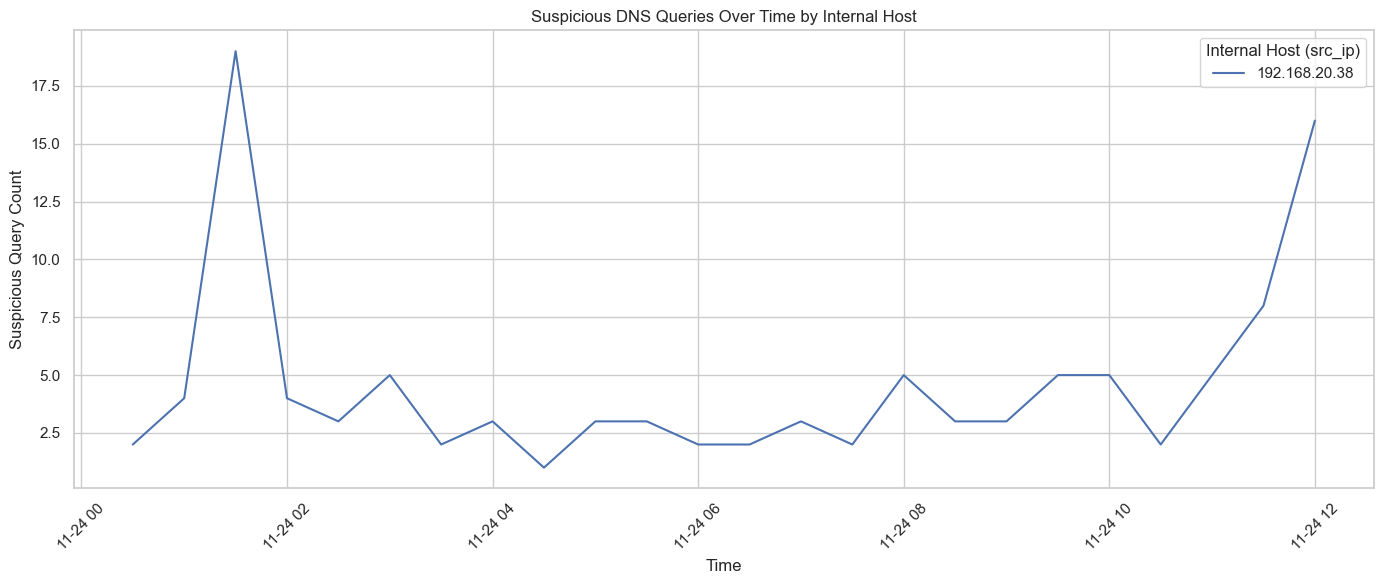

In [73]:
grouped = suspicious_queries.groupby(
    [pd.Grouper(key='timestamp', freq='30min'), 'src_ip']
).size().unstack().fillna(0)

# Then plot as before
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped)
plt.title("Suspicious DNS Queries Over Time by Internal Host")
plt.xlabel("Time")
plt.ylabel("Suspicious Query Count")
plt.xticks(rotation=45)
plt.legend(title='Internal Host (src_ip)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/suspicious_queries_per_client_ip.png')
plt.show()

In [2]:
import ipywidgets as widgets
from IPython.display import display
import io
import json

upload_widget = widgets.FileUpload(accept='.json', multiple=False)

def handle_upload(change):
    if upload_widget.value:
        for filename, file_info in upload_widget.value.items():
            content = file_info['content']
            print(f"Received file: {filename}")
            data = json.load(io.BytesIO(content))
            print(f"First record: {data[0] if isinstance(data, list) else str(data)[:200]}")

upload_widget.observe(handle_upload, names='value')
display(upload_widget)


FileUpload(value=(), accept='.json', description='Upload')

In [4]:
!jupyter labextension list

JupyterLab v4.4.2
C:\Users\hmaos\Documents\dev\phd\share\jupyter\labextensions
        anywidget v0.9.18 enabled ok
        jupyterlab_pygments v0.3.0 enabled ok (python, jupyterlab_pygments)
        nbdime-jupyterlab v3.0.2 enabled ok
        @jupyter-notebook/lab-extension v7.4.2 enabled ok
        @jupyter-widgets/jupyterlab-manager v5.0.15 enabled ok (python, jupyterlab_widgets)
        @jupyterlab/git v0.51.1 enabled ok (python, jupyterlab-git)



In [5]:
import ipywidgets as widgets
from IPython.display import display

upload_widget = widgets.FileUpload(accept='.json', multiple=False)

def handle_upload(change):
    for filename, fileinfo in upload_widget.value.items():
        print(f"Uploaded file: {filename}, Size: {len(fileinfo['content'])} bytes")

upload_widget.observe(handle_upload, names='value')
display(upload_widget)


FileUpload(value=(), accept='.json', description='Upload')